# Result 

![result-merged-image](./image/result-merge.png)

In [33]:
import cv2
import import_ipynb
import numpy as np
from matplotlib import pyplot as plt
from finder_finder_fun import find_circle_center_voting


# Preprocessing

- Read image as a BGR format using openCV
- Convert BGR image to 1 channel grayscale
- Applies Gaussian smoothing with a 5×5 kernel to reduce high-frequency noise
- Binarizes the image using a fixed threshold (threshold_val=40)
- Performs opening to remove small white pepper noise
- Figuring labels connected regions in the binary image and filtering "pepper noise" again 

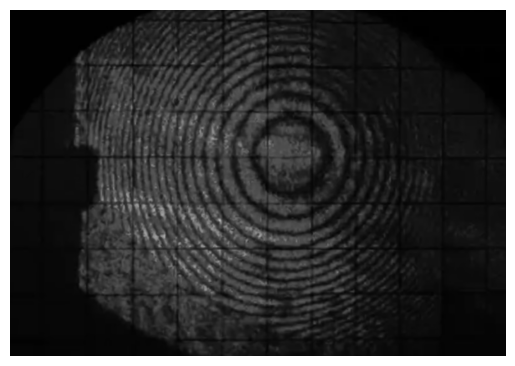

In [34]:
#Read and preprocessing
img = cv2.imread("image/test_img.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

blur_rgb = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
plt.imshow(blur_rgb)
plt.axis('off')
plt.show()

## Thresholding

**Threshold value:** 40

After multiple rounds of empirical tuning, I determined that a threshold value of 40 provides the best balance.

This setting allows the bright and dark fringes in the interference pattern to remain clearly visible, while significantly suppressing background noise and artifacts. 

The binary image retains essential structural features without being overwhelmed by minor disturbances, making it an effective preprocessing step for downstream morphological and contour-based operations.

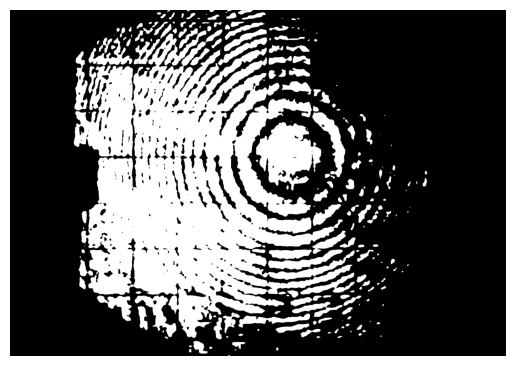

In [35]:
#Thresholding
threshold_val = 40
_, binary = cv2.threshold(blur, threshold_val, 255, cv2.THRESH_BINARY)

binary_rgb = cv2.cvtColor(binary, cv2.COLOR_BGR2RGB)
plt.imshow(binary_rgb)
plt.axis('off')
plt.show()

### Morphological Opening

To remove small isolated white noise from the binary image, I applied a **morphological opening** operation, which consists of an erosion followed by a dilation.

**Kernel shape**: 4×4 rectangular structuring element  

_It's seems useless, and you can see that there is almost no change before and after application_


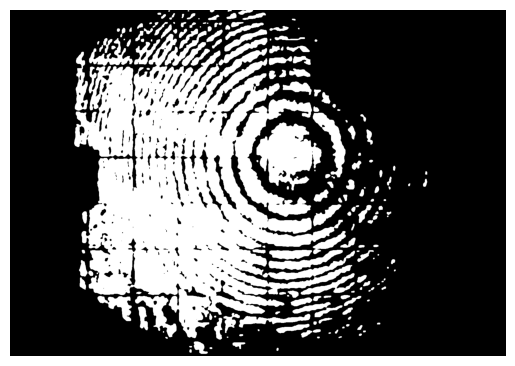

In [36]:
#Open operation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

opened_rgb = cv2.cvtColor(opened, cv2.COLOR_BGR2RGB)
plt.imshow(opened_rgb)
plt.axis('off')
plt.show()

### Connected Component Filtering

After morphological cleaning, I performed **connected component analysis** to identify and isolate meaningful regions based on area.

- **connectedComponentsWithStats** provides detailed statistics (`area`, `bounding box`, etc.) for each connected region.
- I skipped the background (`i = 0`) and filtered components by **area size** between **300 and 2800** pixels.
- This filtering helps exclude both small noise blobs and overly large irrelevant regions, retaining only target-like features in the image.
- The result is a clean binary mask (`clean`) containing candidate areas suitable for further processing such as center detection.


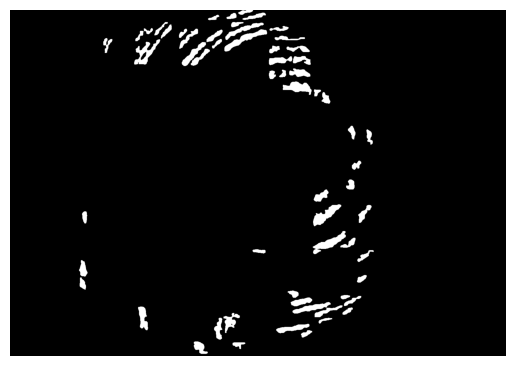

In [37]:
#clean
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)
clean = np.zeros_like(gray)

for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 300 < area < 2800:
        clean[labels == i] = 255

clean_rgb = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB)
plt.imshow(clean_rgb)
plt.axis('off')
plt.show()

### Voting

The specific method is defined in the `finder_finder_fun.ipynb` file.

To locate the center of the circular interference pattern, I used a custom **voting-based center detection** algorithm:

- **Input**: preprocessed image 
- **Method**: This function scans the bright regions and allows each pixel to "vote" for possible circle centers within a defined radius. The point with the highest votes is firstly considered the most probable center.

This method is robust to slight distortions and noise, and works well for detecting approximate geometric centers in fringe-like patterns.

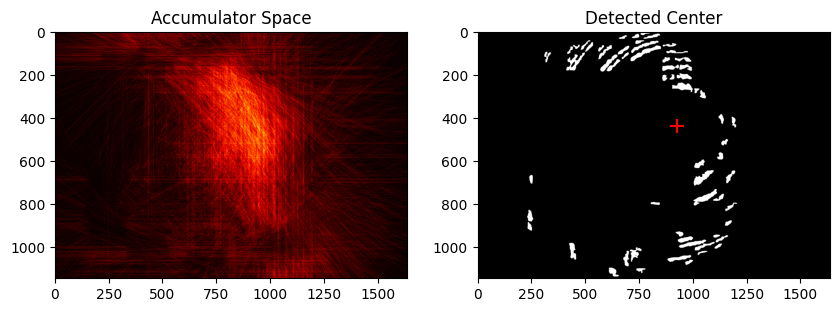

In [38]:
x0, y0 = find_circle_center_voting(clean,100)

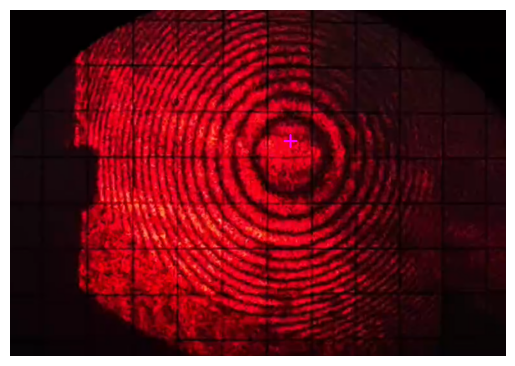

In [39]:
output = img.copy()
x0, y0 = int(x0), int(y0)
cross_len = 20

cv2.line(output, (x0 - cross_len, y0), (x0 + cross_len, y0), (255, 0, 255), thickness=5)
cv2.line(output, (x0, y0 - cross_len), (x0, y0 + cross_len), (255, 0, 255), thickness=5)

output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output_rgb)
plt.axis('off')
plt.show()